In [6]:
import numpy as np, pandas as pd
import warnings
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
dataset = pd.read_csv("../Datasets/taxi_trips_2020.csv")
dataset = pd.DataFrame(dataset)

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3889032 entries, 0 to 3889031
Data columns (total 24 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Trip ID                     object 
 1   Taxi ID                     object 
 2   Trip Start Timestamp        object 
 3   Trip End Timestamp          object 
 4   Trip Seconds                float64
 5   Trip Miles                  float64
 6   Pickup Census Tract         float64
 7   Dropoff Census Tract        float64
 8   Pickup Community Area       float64
 9   Dropoff Community Area      float64
 10  Fare                        float64
 11  Tips                        float64
 12  Tolls                       float64
 13  Extras                      float64
 14  Trip Total                  float64
 15  Payment Type                object 
 16  Company                     object 
 17  Pickup Centroid Latitude    float64
 18  Pickup Centroid Longitude   float64
 19  Pickup Centroid Locat

In [10]:
print(len(dataset["Taxi ID"].unique()))

4484


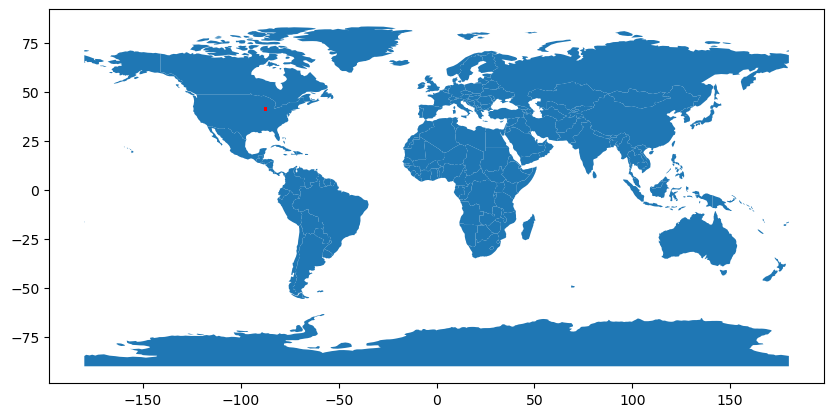

In [11]:
geometry = [Point(xy) for xy in zip(dataset['Pickup Centroid Longitude'], dataset['Pickup Centroid Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=1);